<a href="https://colab.research.google.com/github/toshineb/ARIMA-SARIMA-ARIMAX/blob/main/ARIMA%2C_SARIMA%2C_ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy pmdarima matplotlib scipy statsmodels pandas_datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True


In [ ]:
spy = yf.download("SPY", start="2018-01-01", auto_adjust=True, progress=False, group_by='ticker')
spy.head()

Ticker             SPY                                              
Price             Open        High         Low       Close    Volume
Date                                                                
2018-01-02  237.085910  237.944533  236.696430  237.909119  86655700
2018-01-03  238.077344  239.564463  238.077344  239.413971  90070400
2018-01-04  240.060166  240.909929  239.475946  240.423065  80636400
2018-01-05  241.219708  242.149134  240.724011  242.025223  83524000
2018-01-08  241.927877  242.627175  241.635781  242.467850  57319200

In [ ]:
# 2.1 Pull SPY daily data
spy = yf.download("SPY", start="2018-01-01", auto_adjust=True, progress=False, group_by='ticker')
spy = spy["SPY"][["Close"]].rename(columns={"Close": "spy_close"})

# 2.2 Pull US interest rate data (Effective Federal Funds Rate) from FRED
# FRED series ID: "FEDFUNDS"
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start="2018-01-01")
fedfunds.columns = ["fed_funds_rate"]

# Merge
df = spy.merge(fedfunds, left_index=True, right_index=True, how="inner")

# Create daily returns for SPY (this will be our target variable to model)
df["spy_ret"] = df["spy_close"].pct_change()

# Create daily log-compounded for SPY
df["log_ret"] = np.log(df["spy_close"] / df["spy_close"].shift(1))

# We forward fill the Fed Funds rate because the rate is not updated every single trading day
df["fed_funds_rate"] = df["fed_funds_rate"].ffill()

# Drop initial NaNs
df = df.dropna()

df.head()

,spy_close,fed_funds_rate,spy_ret,log_ret
2018-03-01,236.962067,1.51,-0.049293,-0.050549
2018-05-01,235.493729,1.70,-0.006197,-0.006216
2018-06-01,243.154495,1.82,0.032531,0.032013
2018-08-01,250.727417,1.91,0.031144,0.030669
2018-10-01,261.610229,2.19,0.043405,0.042489


/tmp/ipython-input-2938960782.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


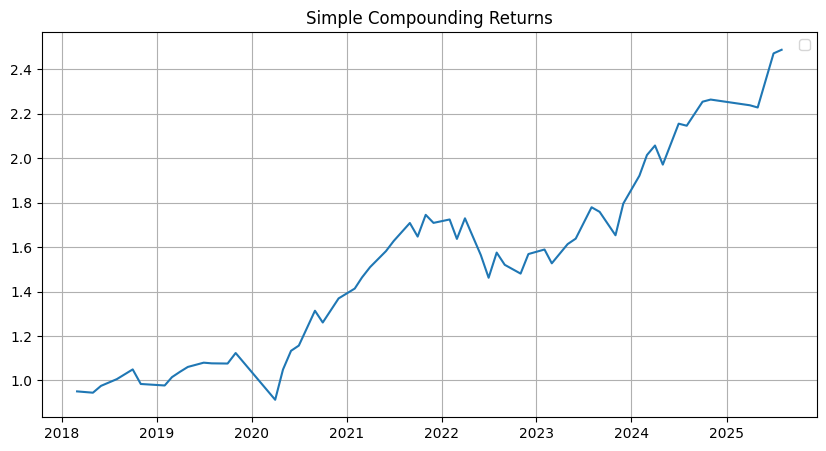

/tmp/ipython-input-2938960782.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


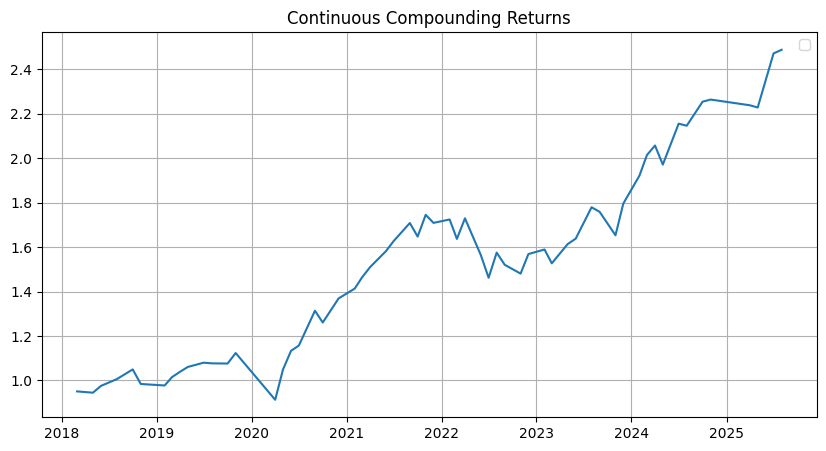

In [ ]:
plt.figure(figsize=(10,5))
plt.plot((1 + df["spy_ret"]).cumprod())
plt.legend()
plt.title("Simple Compounding Returns")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.exp(df["log_ret"].cumsum()))
plt.legend()
plt.title("Continuous Compounding Returns")
plt.show()


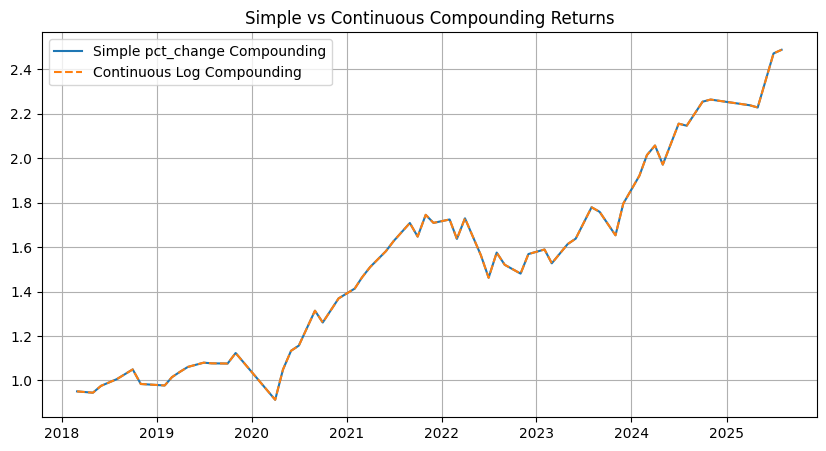

In [ ]:
plt.figure(figsize=(10,5))
plt.plot((1 + df["spy_ret"]).cumprod(), label="Simple pct_change Compounding")
plt.plot(np.exp(df["log_ret"].cumsum()), label="Continuous Log Compounding", linestyle="--")
plt.legend()
plt.title("Simple vs Continuous Compounding Returns")
plt.show()


In [ ]:
def adf_test(series, name="series"):
    result = adfuller(series.dropna(), autolag="AIC")
    print(f"ADF Test on '{name}'")
    print("  Test Statistic:", result[0])
    print("  p-value:", result[1])
    print("  Critical Values:", result[4])
    print("  Stationary?" , "Yes" if result[1] < 0.05 else "No", "\n")

adf_test(df["spy_ret"], "SPY Returns")
adf_test(df["fed_funds_rate"].diff(), "Fed Funds Rate First Difference")


ADF Test on 'SPY Returns'
  Test Statistic: -10.032826684853307
  p-value: 1.568551146505527e-17
  Critical Values: {'1%': np.float64(-3.548493559596539), '5%': np.float64(-2.912836594776334), '10%': np.float64(-2.594129155766944)}
  Stationary? Yes 

ADF Test on 'Fed Funds Rate First Difference'
  Test Statistic: -2.602932527785533
  p-value: 0.0923926870495651
  Critical Values: {'1%': np.float64(-3.552928203580539), '5%': np.float64(-2.9147306250000002), '10%': np.float64(-2.595137155612245)}
  Stationary? No 



In [ ]:

import itertools
from pandas_datareader import data as pdr

# Ensure df is created
# 2.1 Pull SPY daily data
spy = yf.download("SPY", start="2018-01-01", auto_adjust=True, progress=False, group_by='ticker')
spy = spy["SPY"][["Close"]].rename(columns={"Close": "spy_close"})

# 2.2 Pull US interest rate data (Effective Federal Funds Rate) from FRED
# FRED series ID: "FEDFUNDS"
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start="2018-01-01")
fedfunds.columns = ["fed_funds_rate"]

# 2.3 Merge
df = spy.merge(fedfunds, left_index=True, right_index=True, how="inner")

# 2.4 Create daily returns for SPY (this will be our target variable to model)
df["spy_ret"] = df["spy_close"].pct_change()

# We forward fill the Fed Funds rate because the rate is not updated every single trading day
df["fed_funds_rate"] = df["fed_funds_rate"].ffill()

# Drop initial NaNs
df = df.dropna()

y_full = df["spy_ret"].dropna()

p_values = [0,1,2]
d_values = [0]          # since spy_ret is already differenced/return
q_values = [0,1,2]

P_values = [0,1]
D_values = [0]          # we assume no seasonal differencing first
Q_values = [0,1]
s = 5                   # 5-day seasonality guess

results_table = []

for p,d,q in itertools.product(p_values, d_values, q_values):
    for P,D,Q in itertools.product(P_values, D_values, Q_values):
        order = (p,d,q)
        seasonal_order = (P,D,Q,s)
        try:
            model = sm.tsa.statespace.SARIMAX(
                y_full,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)
            results_table.append({
                "order": order,
                "seasonal_order": seasonal_order,
                "aic": res.aic,
                "bic": res.bic
            })
        except Exception as e:
            # some combos won't converge; skip them
            continue

results_df = pd.DataFrame(results_table)
results_df = results_df.sort_values("aic").reset_index(drop=True)
results_df.head(10)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/di

,order,seasonal_order,aic,bic
0,"(0, 0, 0)","(0, 0, 0, 5)",-160.672910,-158.612467
1,"(1, 0, 0)","(0, 0, 0, 5)",-160.223476,-156.102590
2,"(0, 0, 1)","(0, 0, 0, 5)",-156.148261,-152.062158
3,"(2, 0, 0)","(0, 0, 0, 5)",-154.658159,-148.529005
4,"(1, 0, 1)","(0, 0, 0, 5)",-154.524627,-148.395473
5,"(1, 0, 2)","(0, 0, 0, 5)",-154.257313,-146.155906
6,"(2, 0, 1)","(0, 0, 0, 5)",-153.176565,-145.004360
7,"(2, 0, 2)","(0, 0, 0, 5)",-152.294341,-142.167582
8,"(0, 0, 2)","(0, 0, 0, 5)",-152.089873,-146.013818
9,"(0, 0, 1)","(1, 0, 0, 5)",-148.644568,-142.677616


In [ ]:
# Fit the SARIMA model to the full data to get residuals
# Using the same order as the SARIMA forecasting section (cell nVvsWzKLhxgu)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd

# Ensure df is created and y_full is defined
spy = yf.download("SPY", start="2018-01-01", auto_adjust=True, progress=False, group_by='ticker')
spy = spy["SPY"][["Close"]].rename(columns={"Close": "spy_close"})

fedfunds = pdr.DataReader("FEDFUNDS", "fred", start="2018-01-01")
fedfunds.columns = ["fed_funds_rate"]

df = spy.merge(fedfunds, left_index=True, right_index=True, how="inner")
df["spy_ret"] = df["spy_close"].pct_change()
df["fed_funds_rate"] = df["fed_funds_rate"].ffill()
df = df.dropna()

y_full = df["spy_ret"].dropna()


sarima_full_model = SARIMAX(
    y_full, # Assuming y_full is already defined and contains the full SPY returns
    order=(1,0,1),
    seasonal_order=(1,0,1,5),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

best_sarima_res = sarima_full_model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
split_date = "2024-01-01"  # use pre-2024 as training, post-2024 as test

train = df.loc[df.index < split_date].copy()
test  = df.loc[df.index >= split_date].copy()

print(train.shape, test.shape)

(47, 3) (12, 3)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Target series
y_train = train["spy_ret"]

# Fit ARIMA(1,0,1)
model_arima = ARIMA(y_train, order=(1,0,1))
result_arima = model_arima.fit()

print(result_arima.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                spy_ret   No. Observations:                   47
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  68.301
Date:                Fri, 31 Oct 2025   AIC                           -128.601
Time:                        18:56:15   BIC                           -121.201
Sample:                             0   HQIC                          -125.816
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0143      0.007      2.111      0.035       0.001       0.028
ar.L1         -0.2072      0.378     -0.548      0.584      -0.949       0.534
ma.L1         -0.1073      0.428     -0.251      0.8

In [ ]:
# We'll do rolling-style forecast to mimic live trading:
preds_arima = []

history = y_train.copy()

for t in range(len(test)):
    # fit on the data we have so far
    model = ARIMA(history, order=(1,0,1)).fit()
    # 1-step ahead forecast
    forecast = model.forecast(steps=1)
    preds_arima.append(forecast.iloc[0])
    # append the REALIZED return from test to history, like real time
    history = pd.concat([history, test["spy_ret"].iloc[t:t+1]])

test = test.copy()
test["pred_arima"] = preds_arima

test[["spy_ret", "pred_arima"]].head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

,spy_ret,pred_arima
2024-02-01,0.069883,-0.005717
2024-03-01,0.048344,-0.002780
2024-04-01,0.021317,0.005691
2024-05-01,-0.041769,0.014109
2024-07-01,0.093433,0.030560


In [ ]:
# We'll fit SARIMA directly using the statespace SARIMAX class with no exogenous
sarima_model = SARIMAX(
    y_train,
    order=(1,0,1),
    seasonal_order=(1,0,1,5),  # 5-day seasonality assumption
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()
print(sarima_result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                           spy_ret   No. Observations:                   47
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood                  55.108
Date:                           Fri, 31 Oct 2025   AIC                           -100.216
Time:                                   18:56:21   BIC                            -91.771
Sample:                                        0   HQIC                           -97.162
                                            - 47                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2628      0.526     -0.500      0.617      -1.294       0.768
ma.L1          0.0105      0.593      0.018

In [ ]:
# We'll fit SARIMA directly using the statespace SARIMAX class with no exogenous
sarima_model = SARIMAX(
    y_train,
    order=(1,0,1),
    seasonal_order=(1,0,1,5),  # 5-day seasonality assumption
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()
print(sarima_result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                           spy_ret   No. Observations:                   47
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood                  55.108
Date:                           Fri, 31 Oct 2025   AIC                           -100.216
Time:                                   18:56:22   BIC                            -91.771
Sample:                                        0   HQIC                           -97.162
                                            - 47                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2628      0.526     -0.500      0.617      -1.294       0.768
ma.L1          0.0105      0.593      0.018

In [ ]:
# Ensure train and test DataFrames are correctly created with all necessary columns
split_date = "2024-01-01"
train = df.loc[df.index < split_date].copy()
test  = df.loc[df.index >= split_date].copy()
y_train = train["spy_ret"]
y_test  = test["spy_ret"] # Define y_test here as well

# --- Start of code from cell QGXUUq_vhxbj to ensure pred_arima is available ---
from statsmodels.tsa.arima.model import ARIMA

preds_arima = []
history = y_train.copy()

for t in range(len(test)):
    # fit on the data we have so far
    model = ARIMA(history, order=(1,0,1)).fit()
    # 1-step ahead forecast
    forecast = model.forecast(steps=1)
    preds_arima.append(forecast.iloc[0])
    # append the REALIZED return from test to history, like real time
    history = pd.concat([history, test["spy_ret"].iloc[t:t+1]])

test["pred_arima"] = preds_arima
# --- End of code from cell QGXUUq_vhxbj ---


preds_sarima = []
history_y = y_train.copy()

for t in range(len(test)): # Iterate over the test DataFrame
    model = SARIMAX(
        history_y,
        order=(1,0,1),
        seasonal_order=(1,0,1,5),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    fc = model.forecast(steps=1)
    preds_sarima.append(fc.iloc[0])

    # Append the realized y_test (using the correctly defined y_test)
    history_y = pd.concat([history_y, y_test.iloc[t:t+1]])


test["pred_sarima"] = preds_sarima

test[["spy_ret", "pred_arima", "pred_sarima"]].head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

,spy_ret,pred_arima,pred_sarima
2024-02-01,0.069883,-0.005717,-0.015128
2024-03-01,0.048344,-0.002780,0.004651
2024-04-01,0.021317,0.005691,-0.008804
2024-05-01,-0.041769,0.014109,-0.019045
2024-07-01,0.093433,0.030560,0.027022


In [ ]:
# Ensure df is created and y_full is defined
spy = yf.download("SPY", start="2018-01-01", auto_adjust=True, progress=False, group_by='ticker')
spy = spy["SPY"][["Close"]].rename(columns={"Close": "spy_close"})

fedfunds = pdr.DataReader("FEDFUNDS", "fred", start="2018-01-01")
fedfunds.columns = ["fed_funds_rate"]

df = spy.merge(fedfunds, left_index=True, right_index=True, how="inner")
df["spy_ret"] = df["spy_close"].pct_change()
df["fed_funds_rate"] = df["fed_funds_rate"].ffill()

# Create fed_rate_change before splitting into train/test
df["fed_rate_change"] = df["fed_funds_rate"].diff()

df = df.dropna()

split_date = "2024-01-01"  # use pre-2024 as training, post-2024 as test

train = df.loc[df.index < split_date].copy()
test  = df.loc[df.index >= split_date].copy()


y_train = train["spy_ret"]
y_test  = test["spy_ret"]

X_train = train[["fed_rate_change"]]
X_test  = test[["fed_rate_change"]]

print(train.shape, test.shape)
train[["spy_ret", "fed_rate_change"]].head()

(47, 4) (12, 4)


,spy_ret,fed_rate_change
2018-03-01,-0.049293,0.09
2018-05-01,-0.006196,0.19
2018-06-01,0.032531,0.12
2018-08-01,0.031145,0.09
2018-10-01,0.043404,0.28


In [ ]:
arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1,0,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_result = arimax_model.fit()
print(arimax_result.summary())


                               SARIMAX Results                                
Dep. Variable:                spy_ret   No. Observations:                   47
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  63.373
Date:                Fri, 31 Oct 2025   AIC                           -118.746
Time:                        18:58:31   BIC                           -111.519
Sample:                             0   HQIC                          -116.052
                                 - 47                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
fed_rate_change     0.0290      0.014      2.085      0.037       0.002       0.056
ar.L1              -0.2825      0.801     -0.352      0.725      -1.853       1.288
ma.L1               0.0970      

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
preds_arimax = []

hist_y = y_train.copy()
hist_X = X_train.copy()

for i in range(len(test)):
    # Fit model on all data so far
    model = SARIMAX(
        endog=hist_y,
        exog=hist_X,
        order=(1,0,1),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    # Forecast 1-step ahead using today's exogenous var
    next_exog = X_test.iloc[i:i+1]  # must be DataFrame
    fc = model.forecast(steps=1, exog=next_exog)
    preds_arimax.append(fc.iloc[0])

    # Append the realized y_test and X_test row into history (simulate walking forward in time)
    hist_y = pd.concat([hist_y, y_test.iloc[i:i+1]])
    hist_X = pd.concat([hist_X, X_test.iloc[i:i+1]])

test["pred_arimax"] = preds_arimax

test.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

,spy_close,fed_funds_rate,spy_ret,fed_rate_change,pred_arimax
2024-02-01,478.808868,5.33,0.069883,0.0,-0.017031
2024-03-01,501.956482,5.33,0.048344,0.0,0.002467
2024-04-01,512.656616,5.33,0.021317,0.0,0.015947
2024-05-01,491.243622,5.33,-0.041769,0.0,0.014406
2024-07-01,537.142090,5.33,0.093433,0.0,0.004785


In [ ]:
# Build signal from ARIMAX prediction
test["signal_arimax"] = (test["pred_arimax"] > 0).astype(int)

# Shift by 1 to avoid look-ahead: we only trade AFTER we get the forecast
test["position_arimax"] = test["signal_arimax"].shift(1).fillna(0)

# Strategy return using ACTUAL realized next-day return
test["strat_ret_arimax_gross"] = test["position_arimax"] * test["spy_ret"]

# Trading cost (assume same 5 bps per position change)
cost_per_change = 0.0005
test["pos_change_arimax"] = test["position_arimax"].diff().abs().fillna(0)
test["cost_arimax"] = test["pos_change_arimax"] * cost_per_change

test["strat_ret_arimax_net"] = test["strat_ret_arimax_gross"] - test["cost_arimax"]

# Equity curve
test["equity_curve_arimax"] = (1 + test["strat_ret_arimax_net"]).cumprod()

# Buy & hold on same period for comparison
test["buy_hold_curve"] = (1 + test["spy_ret"]).cumprod()

test[["equity_curve_arimax", "buy_hold_curve"]].tail()

,equity_curve_arimax,buy_hold_curve
2024-11-01,1.118093,1.260645
2025-04-01,1.104829,1.246320
2025-05-01,1.104277,1.240765
2025-07-01,1.224353,1.376304
2025-08-01,1.232421,1.385373


In [ ]:
def sharpe_ratio(returns, periods_per_year=252):
    mean_ret = returns.mean()
    vol = returns.std()
    if vol == 0:
        return np.nan
    daily_sharpe = mean_ret / vol
    return daily_sharpe * np.sqrt(periods_per_year)

def max_drawdown(equity_curve):
    roll_max = equity_curve.cummax()
    dd = (equity_curve / roll_max) - 1
    return dd.min()

rets = test["strat_ret_arimax_net"].dropna()
eq   = test["equity_curve_arimax"].dropna()

total_return = eq.iloc[-1] - 1
ann_sharpe   = sharpe_ratio(rets)
mdd          = max_drawdown(eq)

print("=== ARIMAX Out-of-Sample Performance ===")
print(f"Total Return:        {total_return:.2%}")
print(f"Annualized Sharpe:   {ann_sharpe:.2f}")
print(f"Max Drawdown:        {mdd:.2%}")

=== ARIMAX Out-of-Sample Performance ===
Total Return:        23.24%
Annualized Sharpe:   6.63
Max Drawdown:        -4.18%


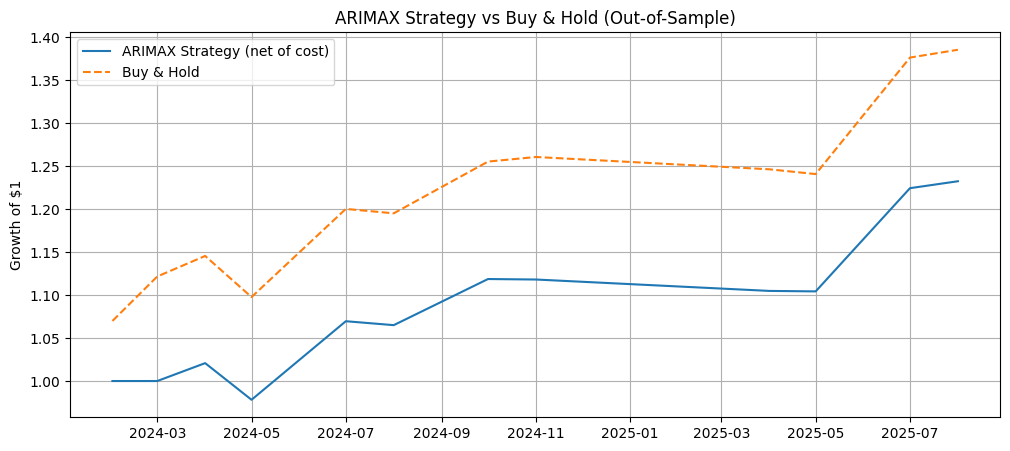

In [ ]:
fig, ax = plt.subplots()
ax.plot(test.index, test["equity_curve_arimax"], label="ARIMAX Strategy (net of cost)")
ax.plot(test.index, test["buy_hold_curve"], label="Buy & Hold", linestyle="--")
ax.set_title("ARIMAX Strategy vs Buy & Hold (Out-of-Sample)")
ax.set_ylabel("Growth of $1")
ax.legend()
plt.show()


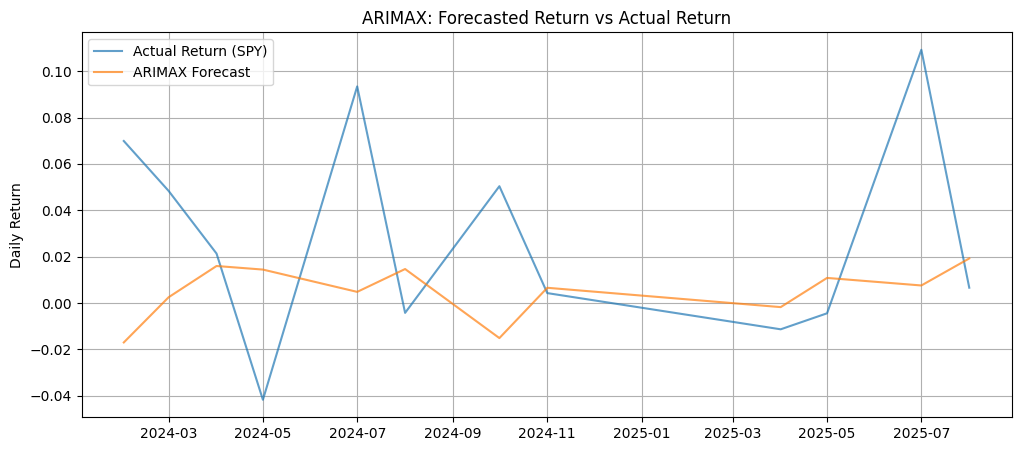

In [ ]:
fig, ax = plt.subplots()

ax.plot(test.index, test["spy_ret"], label="Actual Return (SPY)", alpha=0.7)
ax.plot(test.index, test["pred_arimax"], label="ARIMAX Forecast", alpha=0.7)

ax.set_title("ARIMAX: Forecasted Return vs Actual Return")
ax.set_ylabel("Daily Return")
ax.legend()
plt.show()

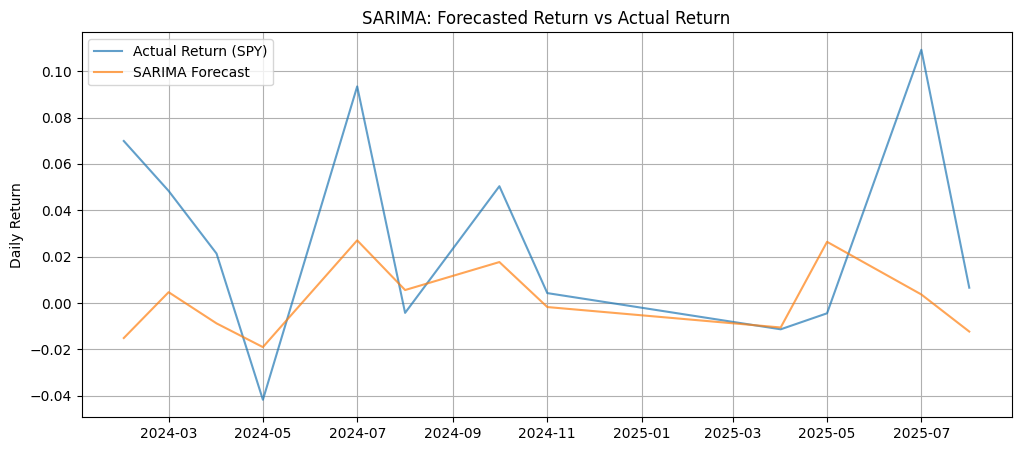

In [ ]:
fig, ax = plt.subplots()

ax.plot(test.index, test["spy_ret"], label="Actual Return (SPY)", alpha=0.7)
ax.plot(test.index, test["pred_sarima"], label="SARIMA Forecast", alpha=0.7)

ax.set_title("SARIMA: Forecasted Return vs Actual Return")
ax.set_ylabel("Daily Return")
ax.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

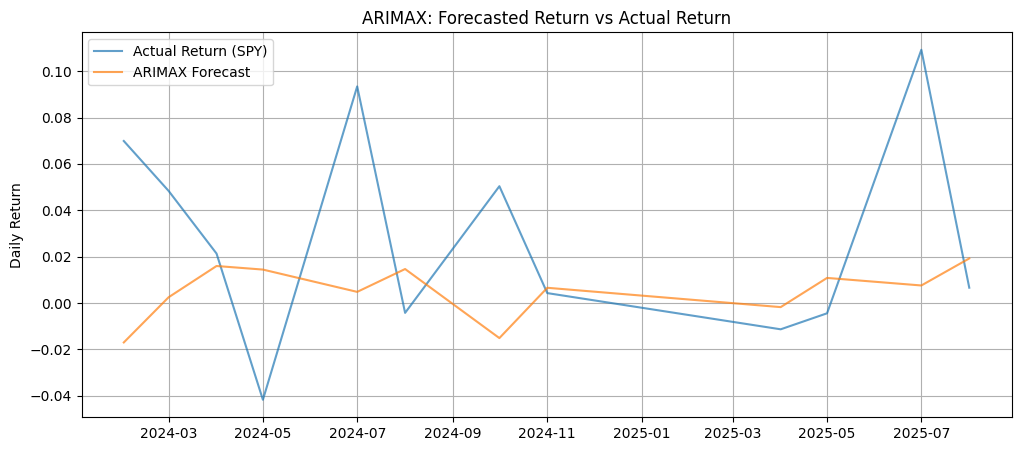

In [ ]:
# Ensure train and test DataFrames are correctly created with all necessary columns
split_date = "2024-01-01"
train = df.loc[df.index < split_date].copy()
test  = df.loc[df.index >= split_date].copy()
y_train = train["spy_ret"]
y_test  = test["spy_ret"]
X_train = train[["fed_rate_change"]]
X_test  = test[["fed_rate_change"]]

# Re-calculate pred_arimax within this cell
preds_arimax = []

hist_y = y_train.copy()
hist_X = X_train.copy()

for i in range(len(test)):
    # Fit model on all data so far
    model = SARIMAX(
        endog=hist_y,
        exog=hist_X,
        order=(1,0,1),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()

    # Forecast 1-step ahead using today's exogenous var
    next_exog = X_test.iloc[i:i+1]  # must be DataFrame
    fc = model.forecast(steps=1, exog=next_exog)
    preds_arimax.append(fc.iloc[0])

    # Append the realized y_test and X_test row into history (simulate walking forward in time)
    hist_y = pd.concat([hist_y, y_test.iloc[i:i+1]])
    hist_X = pd.concat([hist_X, X_test.iloc[i:i+1]])

test["pred_arimax"] = preds_arimax


fig, ax = plt.subplots()

ax.plot(test.index, test["spy_ret"], label="Actual Return (SPY)", alpha=0.7)
ax.plot(test.index, test["pred_arimax"], label="ARIMAX Forecast", alpha=0.7)

ax.set_title("ARIMAX: Forecasted Return vs Actual Return")
ax.set_ylabel("Daily Return")
ax.legend()
plt.show()

In [ ]:
# Last historical date in df
last_date = df.index.max()

# We’ll create a future daily index of business days up to Nov 30, 2026
future_index = pd.date_range(
    start=last_date + pd.tseries.offsets.BDay(1),
    end="2026-11-30",
    freq="B"  # business days
)

len(future_index), future_index[:5], future_index[-5:]

(346,
 DatetimeIndex(['2025-08-04', '2025-08-05', '2025-08-06', '2025-08-07',
                '2025-08-08'],
               dtype='datetime64[ns]', freq='B'),
 DatetimeIndex(['2026-11-24', '2026-11-25', '2026-11-26', '2026-11-27',
                '2026-11-30'],
               dtype='datetime64[ns]', freq='B'))

In [ ]:
# use full history up to 'today'
y_full = df["spy_ret"].dropna()

sarima_full_model = SARIMAX(
    y_full,
    order=(1,0,1),
    seasonal_order=(1,0,1,5),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Forecast future returns for the whole horizon
sarima_forecast_ret = sarima_full_model.forecast(steps=len(future_index))

sarima_forecast_ret = pd.Series(sarima_forecast_ret.values,
                                index=future_index,
                                name="sarima_ret_forecast")
sarima_forecast_ret.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,sarima_ret_forecast
2025-08-04,0.003359
2025-08-05,-0.003516
2025-08-06,-0.002114
2025-08-07,0.032244
2025-08-08,0.001443


In [ ]:
# Recompute fed_rate_change on full df just to be safe
df["fed_rate_change"] = df["fed_funds_rate"].diff()

# Align and drop NaN rows (because diff creates a NaN at start)
arimax_data = df.dropna(subset=["spy_ret", "fed_rate_change"]).copy()

y_full_arimax = arimax_data["spy_ret"]
X_full_arimax = arimax_data[["fed_rate_change"]]

arimax_full_model = SARIMAX(
    endog=y_full_arimax,
    exog=X_full_arimax,
    order=(1,0,1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Build future exogenous values
# assumption: no further shocks in rate => daily fed_rate_change = 0
future_exog = pd.DataFrame(
    {"fed_rate_change": np.zeros(len(future_index))},
    index=future_index
)

# Forecast ARIMAX returns for horizon
arimax_forecast_ret = arimax_full_model.forecast(
    steps=len(future_index),
    exog=future_exog
)

arimax_forecast_ret = pd.Series(arimax_forecast_ret.values,
                                index=future_index,
                                name="arimax_ret_forecast")
arimax_forecast_ret.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,arimax_ret_forecast
2025-08-04,0.015129
2025-08-05,0.013469
2025-08-06,0.011991
2025-08-07,0.010675
2025-08-08,0.009504


In [ ]:
last_price = df["spy_close"].iloc[-1]

# Helper to convert returns → price path
def returns_to_price_path(start_price, future_returns_series):
    # future_returns_series is daily pct returns like 0.0012 = 0.12%
    cum_curve = (1 + future_returns_series).cumprod()
    price_path = start_price * cum_curve
    return price_path

sarima_price_forecast = returns_to_price_path(last_price, sarima_forecast_ret)
arimax_price_forecast = returns_to_price_path(last_price, arimax_forecast_ret)

sarima_price_forecast.name = "sarima_price_forecast"
arimax_price_forecast.name = "arimax_price_forecast"

sarima_price_forecast.head(), arimax_price_forecast.head()

(2025-08-04    622.083763
 2025-08-05    619.896235
 2025-08-06    618.585936
 2025-08-07    638.531542
 2025-08-08    639.452831
 Freq: B, Name: sarima_price_forecast, dtype: float64,
 2025-08-04    629.381267
 2025-08-05    637.858466
 2025-08-06    645.507039
 2025-08-07    652.397918
 2025-08-08    658.598089
 Freq: B, Name: arimax_price_forecast, dtype: float64)

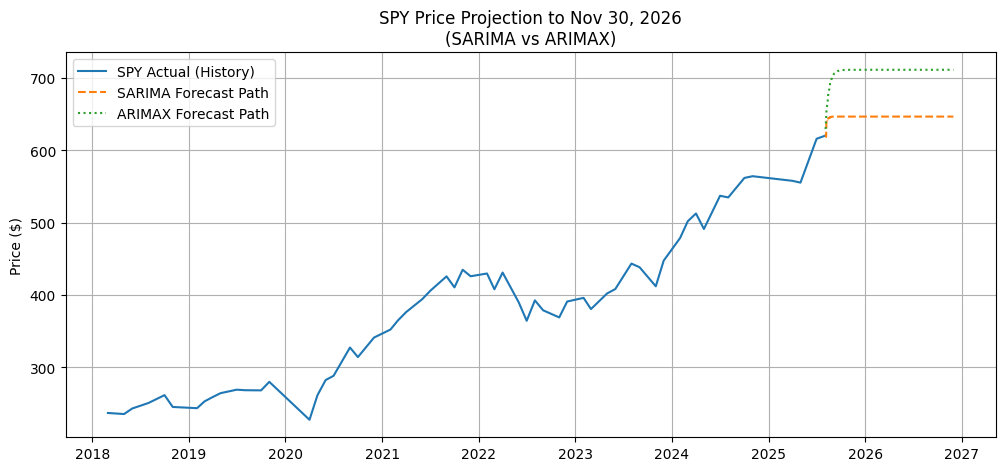

In [ ]:
plot_df = pd.DataFrame({
    "actual_price": df["spy_close"],
})

plot_df = plot_df.join(sarima_price_forecast, how="outer")
plot_df = plot_df.join(arimax_price_forecast, how="outer")

fig, ax = plt.subplots()

# Plot actual historical price
ax.plot(plot_df.index, plot_df["actual_price"], label="SPY Actual (History)")

# Plot SARIMA projected path
ax.plot(plot_df.index, plot_df["sarima_price_forecast"],
        label="SARIMA Forecast Path", linestyle="--")

# Plot ARIMAX projected path
ax.plot(plot_df.index, plot_df["arimax_price_forecast"],
        label="ARIMAX Forecast Path", linestyle=":")

ax.set_title("SPY Price Projection to Nov 30, 2026\n(SARIMA vs ARIMAX)")
ax.set_ylabel("Price ($)")
ax.legend()
plt.show()

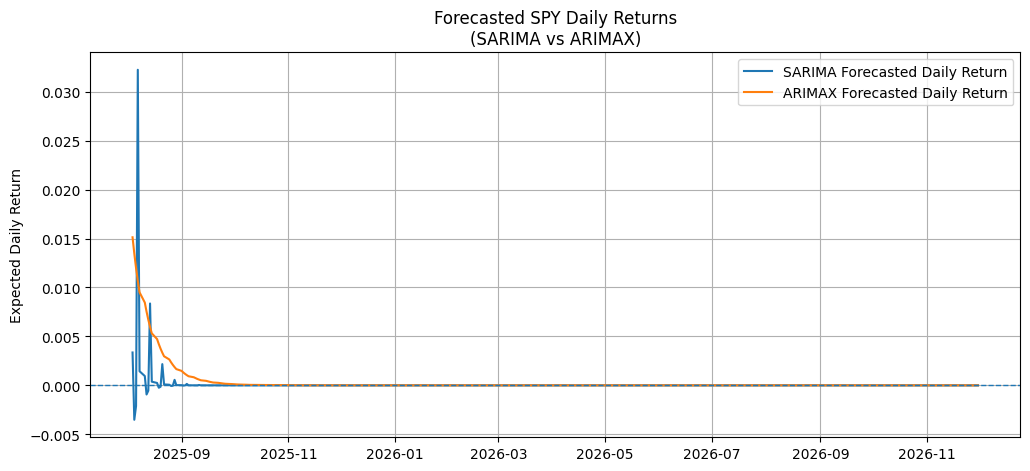

In [ ]:
returns_plot_df = pd.DataFrame({
    "sarima_ret_forecast": sarima_forecast_ret,
    "arimax_ret_forecast": arimax_forecast_ret
})

fig, ax = plt.subplots()

ax.plot(returns_plot_df.index,
        returns_plot_df["sarima_ret_forecast"],
        label="SARIMA Forecasted Daily Return")

ax.plot(returns_plot_df.index,
        returns_plot_df["arimax_ret_forecast"],
        label="ARIMAX Forecasted Daily Return")

ax.axhline(0, linestyle="--", linewidth=1)

ax.set_title("Forecasted SPY Daily Returns\n(SARIMA vs ARIMAX)")
ax.set_ylabel("Expected Daily Return")
ax.legend()
plt.show()

In [ ]:
# We'll work with the full df (already merged earlier) and keep only what we need
price_df = df[["spy_close", "fed_funds_rate"]].copy()

# Forward-fill fed funds rate (already done before, just to be safe)
price_df["fed_funds_rate"] = price_df["fed_funds_rate"].ffill()

# Make sure it's daily with no missing business days in between
price_df = price_df.sort_index()
price_df.head()


,spy_close,fed_funds_rate
2018-03-01,236.962006,1.51
2018-05-01,235.493759,1.70
2018-06-01,243.154541,1.82
2018-08-01,250.727493,1.91
2018-10-01,261.610168,2.19


In [ ]:
last_date = price_df.index[-1]
forecast_horizon = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    end="2026-10-31",
    freq="B"  # business days
)

len(forecast_horizon), forecast_horizon[:5], forecast_horizon[-5:]


(325,
 DatetimeIndex(['2025-08-04', '2025-08-05', '2025-08-06', '2025-08-07',
                '2025-08-08'],
               dtype='datetime64[ns]', freq='B'),
 DatetimeIndex(['2026-10-26', '2026-10-27', '2026-10-28', '2026-10-29',
                '2026-10-30'],
               dtype='datetime64[ns]', freq='B'))

In [ ]:
last_rate = price_df["fed_funds_rate"].iloc[-1]

future_exog = pd.DataFrame(
    {
        "fed_funds_rate": [last_rate] * len(forecast_horizon)
    },
    index=forecast_horizon
)

future_exog.head()

,fed_funds_rate
2025-08-04,4.33
2025-08-05,4.33
2025-08-06,4.33
2025-08-07,4.33
2025-08-08,4.33


In [ ]:
# SARIMA = SARIMAX with no exog
sarima_price_model = SARIMAX(
    price_df["spy_close"],
    order=(1,1,1),            # (p,d,q) - d=1 since price is nonstationary
    seasonal_order=(1,1,1,5), # (P,D,Q,s) assume 5-day seasonality on business days
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_price_res = sarima_price_model.fit()
print(sarima_price_res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         spy_close   No. Observations:                   59
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                -209.287
Date:                           Fri, 31 Oct 2025   AIC                            428.574
Time:                                   19:05:40   BIC                            437.717
Sample:                                        0   HQIC                           431.999
                                            - 59                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2414      0.552     -0.438      0.662      -1.323       0.840
ma.L1         -0.0412      0.626     -0.066

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
sarima_forecast_res = sarima_price_res.get_forecast(steps=len(forecast_horizon))
sarima_pred_mean = sarima_forecast_res.predicted_mean
sarima_conf_int = sarima_forecast_res.conf_int()

# Attach index = future dates
sarima_pred_mean.index = forecast_horizon
sarima_conf_int.index = forecast_horizon

sarima_pred_mean.head()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
2025-08-04,619.443183
2025-08-05,617.815016
2025-08-06,630.056183
2025-08-07,644.270375
2025-08-08,659.063788


In [ ]:
sarimax_price_model = SARIMAX(
    endog=price_df["spy_close"],
    exog=price_df[["fed_funds_rate"]],
    order=(1,0,1),
    seasonal_order=(1,1,1,5),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_price_res = sarimax_price_model.fit()
print(sarimax_price_res.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                         spy_close   No. Observations:                   59
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 5)   Log Likelihood                -213.280
Date:                           Fri, 31 Oct 2025   AIC                            438.561
Time:                                   19:06:58   BIC                            449.662
Sample:                                        0   HQIC                           442.738
                                            - 59                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
fed_funds_rate    -3.9403      5.448     -0.723      0.470     -14.619       6.738
ar.L1              1.0173      

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
sarimax_forecast_res = sarimax_price_res.get_forecast(
    steps=len(forecast_horizon),
    exog=future_exog
)

sarimax_pred_mean = sarimax_forecast_res.predicted_mean
sarimax_conf_int = sarimax_forecast_res.conf_int()

# Give both forecast series the right future index
sarimax_pred_mean.index = forecast_horizon
sarimax_conf_int.index = forecast_horizon

sarimax_pred_mean.head()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
2025-08-04,619.967840
2025-08-05,626.434220
2025-08-06,641.377891
2025-08-07,657.599032
2025-08-08,676.705898


In [ ]:
plot_df = pd.DataFrame(index=price_df.index.append(forecast_horizon))

plot_df["spy_close_hist"] = price_df["spy_close"]

plot_df["sarima_forecast"] = np.nan
plot_df.loc[forecast_horizon, "sarima_forecast"] = sarima_pred_mean.values

plot_df["sarimax_forecast"] = np.nan
plot_df.loc[forecast_horizon, "sarimax_forecast"] = sarimax_pred_mean.values

plot_df.tail()


,spy_close_hist,sarima_forecast,sarimax_forecast
2026-10-26,NaN,2981.924032,3048.312680
2026-10-27,NaN,2980.932711,3047.116313
2026-10-28,NaN,2993.099350,3059.639617
2026-10-29,NaN,3007.117630,3074.295197
2026-10-30,NaN,3021.955957,3089.316029


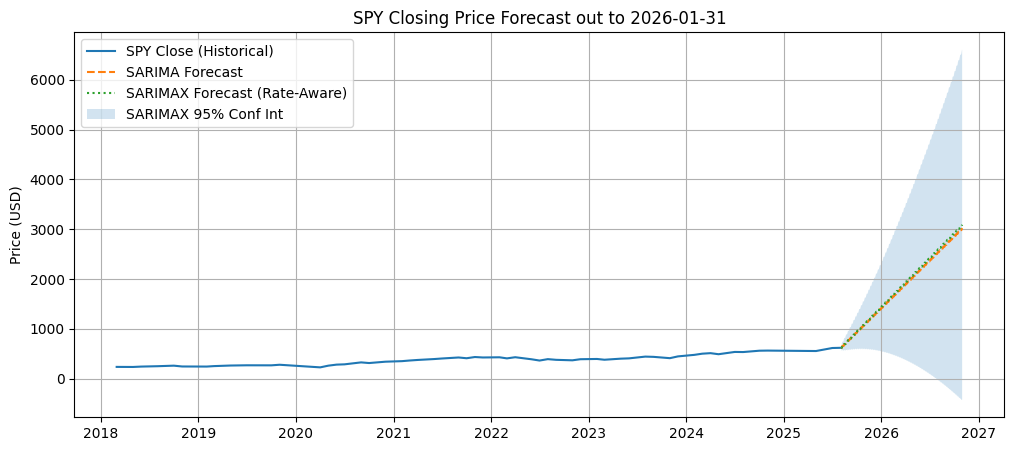

In [ ]:
fig, ax = plt.subplots()

# Plot historical SPY close
ax.plot(plot_df.index, plot_df["spy_close_hist"], label="SPY Close (Historical)")

# Plot SARIMA forecast
ax.plot(plot_df.index, plot_df["sarima_forecast"], linestyle="--", label="SARIMA Forecast")

# Plot SARIMAX forecast
ax.plot(plot_df.index, plot_df["sarimax_forecast"], linestyle=":", label="SARIMAX Forecast (Rate-Aware)")

# Add SARIMAX confidence interval shading
sarimax_lower = sarimax_conf_int.iloc[:, 0]
sarimax_upper = sarimax_conf_int.iloc[:, 1]

ax.fill_between(
    sarimax_pred_mean.index,
    sarimax_lower,
    sarimax_upper,
    alpha=0.2,
    step="pre",
    label="SARIMAX 95% Conf Int"
)

ax.set_title("SPY Closing Price Forecast out to 2026-01-31")
ax.set_ylabel("Price (USD)")
ax.legend()
plt.show()
